# Conceptual Test

In [1]:
import torch
import torch.nn as nn
# import torch.optim
import numpy as np
import matplotlib.pyplot as plt
torch.__version__

'1.0.1.post2'

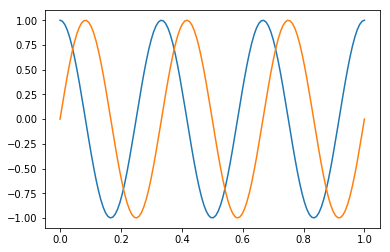

In [3]:
f = 3
t = np.linspace(0, 1, 128)
sig = np.exp(1j*2*np.pi*f*t)
# sig.dtype
plt.plot(t, sig.real)
plt.plot(t, sig.imag)
plt.show()
# sig = np.vstack([sig.real, sig.imag])
# sig.shape

In [22]:
class CVcnn(torch.nn.Module):
    def __init__(self):
        super(CVcnn, self).__init__()
        
        self.conv1_r = nn.Conv1d(1, 8, 5)
        self.conv1_i = nn.Conv1d(1, 8, 5)
        
        self.conv2_r = nn.Conv1d(8, 8, 5)
        self.conv2_i = nn.Conv1d(8, 8, 5)
        
    def forward(self, x_r, x_i):
        (y_r, y_i) = (self.conv1_r(x_r) - self.conv1_i(x_i),
                      self.conv1_r(x_i) + self.conv1_i(x_r))
        
        (y_r, y_i) = (self.conv2_r(y_r) - self.conv2_i(y_i),
                      self.conv2_r(y_i) + self.conv2_i(y_r))
        
        return y_r, y_i
    
    
net = CVcnn()
print('Number of parameters: {}'.format(sum(p.numel() for p in net.parameters())))

x_r = torch.from_numpy(sig.real).float().view(1, 1, -1)
x_i = torch.from_numpy(sig.imag).float().view(1, 1, -1)
y_r, y_i = net(x_r, x_i)

print(x_r.shape, y_r.shape)

Number of parameters: 752
torch.Size([1, 1, 128]) torch.Size([1, 8, 120])


In [17]:
class RVcnn(torch.nn.Module):
    def __init__(self):
        super(RVcnn, self).__init__()
        
        self.conv1 = nn.Conv1d(2, 8, 5)
        self.conv2 = nn.Conv1d(8, 8, 5)
#         self.conv1_i = nn.Conv1d(1, 2, 5) 
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
#         y_r = self.conv1_r(x_r) - self.conv1_i(x_i)
#         y_i = self.conv1_r(x_i) + self.conv1_i(x_r)
        return y

net = RVcnn()
print('Number of parameters: {}'.format(sum(p.numel() for p in net.parameters())))

x_r = torch.from_numpy(sig.real).float().view(1, 1, -1)
x_i = torch.from_numpy(sig.imag).float().view(1, 1, -1)
x = torch.cat((x_r, x_i), 1)
y= net(x)

print(x.shape, y.shape)

Number of parameters: 416
torch.Size([1, 2, 128]) torch.Size([1, 8, 120])
